# Lecture : Shallow Graph Feature Learning

## Lab 01 : DeepWalk - Exercise

### Xavier Bresson, Guoji Fu   

Perozzi, Al-Rfou, Skiena, DeepWalk: Online learning of social representations, 2014  
https://arxiv.org/pdf/1403.6652.pdf

Notebook goals :<br>
• Design a random walk extractor <br>
• Implement the deepwalk technique <br>
• Compare visually the deepwalk embedding with networkx visualization <br>


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/07_Shallow_Learning'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install rdkit==2023.09.6 # Install RDKit
    !pip install dgl==1.0.0 # Install DGL


In [2]:
# Libraries
import pickle
import sys; sys.path.insert(0, 'lib/')
from lib.utils import Molecule
from rdkit import Chem
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import random
from lib.utils import compute_ncut


## Load dataset and select one molecule

Loading data
tensor([0, 5, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 4, 0, 0, 0, 2])
tensor([ 0,  0,  1,  2,  3,  4,  0,  0,  5,  6,  7,  8,  9, 10,  1, 11,  1, 12,
         0, 13, 14, 15,  2])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0

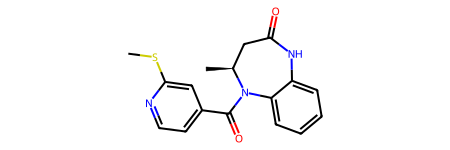

In [3]:
print('Loading data')
data_folder_pytorch = 'datasets/ZINC_pytorch/'
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    dataset=pickle.load(f)

# Select one molecule
idx = 12
mol = dataset[idx]
print(mol.atom_type)
print(mol.atom_type_pe)
print(mol.bond_type)
print(mol.bag_of_atoms)
print(mol.logP_SA_cycle_normalized)
print(mol.smile)
Chem.MolFromSmiles(mol.smile)


## Exercise 1 : Design a random walk extractor

### Question 1.1 : Implement a class that generates a random walk path.

Hints:
- Sample the next node from the RW probability `prob_j = sample(RW[i,:]`.
- Use Bernoulli sampling with function `torch.distributions.Categorical(prob).sample()`.


In [6]:
class sample_RW_path:

    def __init__(self, num_steps, RW):
        self.num_steps = num_steps # number of steps
        self.RW = RW # random walk matrix
        self.num_nodes = RW.size(0) # number of nodes

    def sample_walk(self, idx_start):
        idx = torch.tensor(idx_start).long() # starting index of the walk
        RWpath = [idx] # random walk path
        for _ in range(self.num_steps-1):
            ########################################
            # YOUR CODE START
            # sample the next node from the RW probability prob_j = sample(RW[i,:]
            # use Bernoulli sampling with torch.distributions.Categorical(prob).sample()
            ########################################

            idx = torch.distributions.Categorical(self.RW[idx,:]).sample()

            ########################################
            # YOUR CODE END
            ########################################

            RWpath.append(idx) # append sampled node to the path
        RWpath = torch.stack(RWpath).flatten() # path format = torch.tensor([idx_1, idx_2, ..., idx_num_steps])
        return RWpath



### Question 1.2 : Use the previously defined function to sample a random walk path.

Hints:
- Step 1: Compute the RW operator with $RW = D^{-1}A$.
- Step 2: Choose the number of RW steps.
- Step 3: Use `sample_RW_path()` to instantiate a RW class.
- Step 4: Apply `sample_walk()` to extract a RW path.
  

In [7]:
A = (mol.bond_type>0).float() # Adjacency matrix
D = A.sum(dim=0) # Degree vector

########################################
# YOUR CODE START
########################################

# Step 1: # Compute the RW operator
# Compute the inverse degree matrix
Dinv = (D**(-1)).diag()

# Compute RW matrix
RW = torch.mm(Dinv,A)

# Step 2: choose the number of RW steps
num_RW_steps = 8

# Step 3: instantiate RW class
generator = sample_RW_path(num_RW_steps, RW)

# Step 4: sample RW path starting with index=7
walk = generator.sample_walk(7)

########################################
# YOUR CODE END
########################################

print('RW:',walk)



RW: tensor([7, 5, 6, 5, 4, 5, 7, 8])


### Visualise the sampled RW path

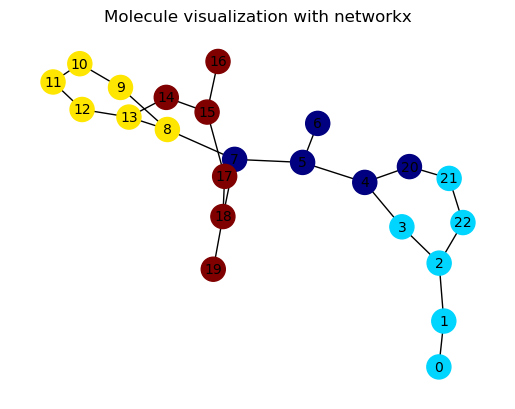

In [8]:
# Check visually RW path correctness
fig = plt.figure()
ax = fig.add_subplot(111)
A_nx = nx.from_numpy_array(A.numpy())
C = compute_ncut(A.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Molecule visualization with networkx')
plt.show()

## Exercise 2 : Implement the DeepWalk paper

### Question 2.1 : Implement a DeepWalk network class and apply it to molecular graphs.

Instructions:
- Step 1: Extract the embedding $h_i$ for node i. You can use the `.unsqueeze()` method.
- Step 2: Extract the embeddings $h_j$ for nodes j in the RW. You may use the `.transpose()` method.
- Step 3: Extract the embeddings $h_k$ for nodes k not in the RW. 


In [9]:
class deepwalk_net(nn.Module):

    def __init__(self, num_nodes, hidden_dim, num_negative):
        super(deepwalk_net, self).__init__()
        print(num_nodes, hidden_dim)
        self.num_nodes = num_nodes
        self.num_negative = num_negative
        self.node_embedding = nn.Embedding(num_nodes, hidden_dim)

    def forward(self, walk):
        walk_list = walk.tolist() # list nodes in RW
        node_list = list(range(self.num_nodes)) # list all nodes
        list_negative = torch.tensor(list(set(node_list) - set(walk_list))) # all possible negative samples
        #list_negative = list_negative[torch.randperm(list_negative.size(0))] # ???
        loss = []
        for i in walk: # loop over all nodes in RW
                       # node i that must predict all other nodes j in RW

            ########################################
            # YOUR CODE START
            ########################################

            # positive samples
            # Step1: extract embedding hi of node i
            hi =  self.node_embedding(i).unsqueeze(0)

            # Step 2: extract embedding hj of nodes j in RW
            j = torch.tensor(list(set(walk_list) - set([i.detach().item()])))
            # hj.size()=(num_RW_steps-1,hidden_dim)
            hj =  self.node_embedding(j).transpose(1,0)

            # negative samples : select randomly "num_negative" nodes which are not in the RW path
            list_negative = list_negative[torch.randperm(list_negative.size(0))][:self.num_negative]

            # Step 3: extract embedding hk of nodes k not in RW
            # hk.size()=(num_negative,hidden_dim)
            hk =  self.node_embedding(list_negative).transpose(1,0)

            ########################################
            # YOUR CODE END
            ########################################

            # compute loss
            loss_i = - ( torch.log(torch.sigmoid(torch.mm(hi,hj))).sum() - 0.25*torch.log(torch.sigmoid(torch.mm(hi,hk))).sum() )
            loss.append(loss_i)
        loss = torch.stack(loss).mean()
        return loss




### Question 2.2 : Instantiate a DeepWalk network

Instructions:
- Select the number of negative samples and use the `deepwalk()` function to instantiate the network.
- Evaluate and compare the performance of DeepWalk networks using different numbers of negative samples.


In [10]:
num_nodes = A.size(0)

########################################
# YOUR CODE START
########################################

# select num_negative = num_RW_steps/4
net = deepwalk_net(num_nodes,2,num_RW_steps//4)

########################################
# YOUR CODE END
########################################

print(net)


23 2
deepwalk_net(
  (node_embedding): Embedding(23, 2)
)


### Train the deepwalk network

In [11]:
# Train the network
optimizer = torch.optim.Adam( net.parameters() , lr=0.001 )
for iter in range(300):
    loss_epoch = 0.0
    for idx in torch.randperm(num_nodes).tolist(): # shuffle ordering of nodes
        walk = generator.sample_walk(idx)
        loss = net(walk)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach()
        with torch.no_grad():
            # centering the embedding coordinates
            # helps optimization by reducing one degree of freedom
            net.node_embedding.weight.sub_(net.node_embedding.weight.mean(dim=0))
    # plot the loss value
    if not iter%10:
        print(iter,loss_epoch/num_nodes)



0 tensor(3.5301)
10 tensor(3.1633)
20 tensor(2.8733)
30 tensor(2.2584)
40 tensor(2.3608)
50 tensor(2.1543)
60 tensor(1.9801)
70 tensor(1.9008)
80 tensor(1.9275)
90 tensor(1.8432)
100 tensor(1.2498)
110 tensor(1.3700)
120 tensor(1.2464)
130 tensor(0.9098)
140 tensor(0.8025)
150 tensor(0.6483)
160 tensor(0.8829)
170 tensor(0.2483)
180 tensor(0.5076)
190 tensor(0.0740)
200 tensor(-0.5665)
210 tensor(-0.2407)
220 tensor(-1.0956)
230 tensor(-1.0769)
240 tensor(-0.9978)
250 tensor(-0.4488)
260 tensor(-0.5179)
270 tensor(-0.3738)
280 tensor(-0.4143)
290 tensor(-0.8865)


### Visualize the node embeddings in 2D

tensor([[ 4.3932, -2.9034],
        [ 3.2863, -2.8629],
        [ 4.0200, -1.2492],
        [ 3.1371, -1.0650],
        [ 1.5095, -2.5409],
        [ 0.4239, -0.4716],
        [ 0.5109, -0.9644],
        [-0.7536, -0.1030],
        [-1.8398,  0.7315],
        [-1.7824,  1.1074],
        [-1.6650,  1.9018],
        [-0.3399,  2.1566],
        [-1.1181,  2.6581],
        [-1.7832,  2.0173],
        [-2.6004,  2.1099],
        [-2.3947,  2.2325],
        [-1.0089,  2.5431],
        [-2.8800,  0.7053],
        [-1.6171,  0.4636],
        [-2.5177,  0.9250],
        [ 1.2614, -2.6460],
        [ 1.2024, -1.9450],
        [ 2.5561, -2.8006]]) torch.Size([23, 2])


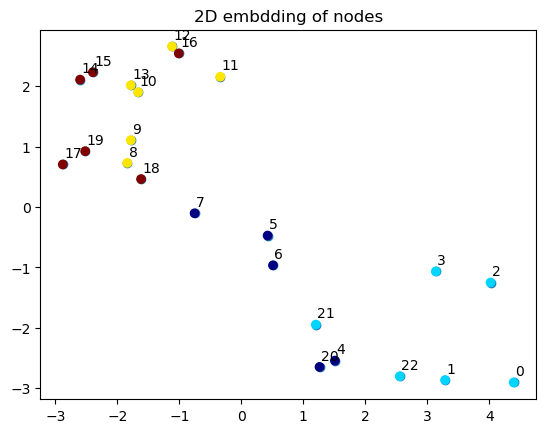

In [12]:
# Visualize the 2D coordinates of the node embeddings
x = net.node_embedding.weight.detach()
print(x,x.size())

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x[:,0], x[:,1])
idx = list(range(num_nodes))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()

### Question 2.3 : Compare visually the deepwalk embedding with the networkx visualization


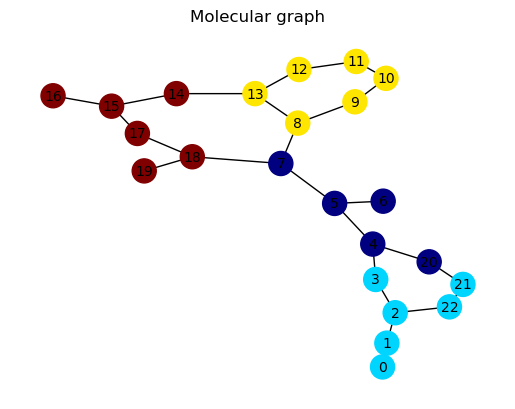

In [13]:
# Compare with graph edges
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Molecular graph')
plt.show()
